In [25]:
import torch
import os
import pickle
import sys
import torch.nn.init as init
import dgl
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [26]:
key=True

In [27]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [28]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [29]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= 3) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


<h3> Data Preparation

<h4> Creating graph features from Train data

In [30]:
checkFile = os.path.isfile("data/dump/speaker_encoder_train.pkl")
encodedSpeakersTrain = []
rangesTrain = []

if not checkFile:
    print("Run first the contextEncoder1 or 2 to generate this file")
else:
    with open('data/dump/speaker_encoder_train.pkl', "rb") as file:
        encodedSpeakersTrain, rangesTrain = pickle.load(file)

checkFile = os.path.isfile("data/dump/adjListTrain.pkl")
adjacencyListTrain = []

if key:
    adjacencyListTrain = get_all_adjacency_list(rangesTrain)
else:
    with open('data/dump/adjListTrain', "rb") as file:
        adjacencyListTrain = pickle.load(file)

In [31]:
file_path = 'embed/u_prime_CNNBiLSTM_train.pkl'

# Load the list from the file using pickle
with open(file_path, 'rb') as file:
    contextualEmbeddingsTrain = pickle.load(file)

In [32]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

<h4> Creating graph features from Test Data

In [33]:
checkFile = os.path.isfile("data/dump/speaker_encoder_test.pkl")
encodedSpeakersTest = []
rangesTest = []

if not checkFile:
    print("Run first the contextEncoder2 to generate this file")
else:
    with open('data/dump/speaker_encoder_test.pkl', "rb") as file:
        encodedSpeakersTest, rangesTest = pickle.load(file)

checkFile = os.path.isfile("data/dump/adjListTest.pkl")
adjacencyListTest = []

if key:
    adjacencyListTest = get_all_adjacency_list(rangesTest)
else:
    with open('data/dump/adjListTest', "rb") as file:
        adjacencyListTest = pickle.load(file)

In [34]:
file_path = 'embed/u_prime_CNNBiLSTM_test.pkl'

# Load the list from the file using pickle
with open(file_path, 'rb') as file:
    contextualEmbeddingsTest = pickle.load(file)

In [35]:
edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

<h4> Creating graph features from Test Data

In [36]:
# TODO repeat the one above

<h3> Get GAT output from each set of data (train, test, validation)

<h4> Instantiating the GAT (1st implementation) for 1 sample train data

In [37]:
num_in_features = len(contextualEmbeddingsTrain[0][0])
num_out_features = len(contextualEmbeddingsTrain[0][0])
num_heads = 4
num_edge_types = 3
gat_layer = GATLayerWithEdgeType(num_in_features, num_out_features, num_heads, num_edge_types)

In [38]:
i = 0  # dialogue id
relationalEmbedding, attentionCoef = gat_layer((contextualEmbeddingsTrain[i], edgeIndicesTrain[i]), edgeTypesTrain[i])
print("h_prime shape: ", relationalEmbedding.shape, "attention_coef shape: ", attentionCoef.shape)

targetNodes = edgeIndicesTrain[i][1].tolist()

sample = {}
sampleEdgetypes = []

for target_i in sorted(set(targetNodes)):
    sample[target_i] = []

for targetNode, idx in zip(targetNodes, range(len(targetNodes))):
    sample[targetNode].append([idx, relationalEmbedding[targetNode][idx].tolist()])

listEdgeIdxTrain, inferredEdgeTypes = get_inferred_edgetypes_GAT(sample, edgeTypesTrain[i])
sampleEdgetypes.append(inferredEdgeTypes)

h_prime shape:  torch.Size([14, 50]) attention_coef shape:  torch.Size([14, 300, 50])


In [39]:
file = open('data/dump/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)
file.close()

label_decoder = list(label_decoder.values())
print(label_decoder)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [40]:
checkFile = os.path.isfile("data/dump/labels_train.pkl")

if checkFile is False:
    print("Please run the contextEncoder2 notebook to save the label file")
else:
    file = open('data/dump/labels_train.pkl', 'rb')
    y_train = pickle.load(file)
    file.close()

In [41]:
checkFile = os.path.isfile("data/dump/labels_test.pkl")

if checkFile is False:
    print("Please run the contextEncoder2 notebook to save the label file")
else:
    file = open('data/dump/labels_test.pkl', 'rb')
    y_test = pickle.load(file)
    file.close()

<h5>Unsupervised Visualizarion

In [42]:
# # Assuming h_prime contains the node embeddings
# utt_size = 13
# labels = torch.tensor(y_train[:utt_size + 1])

# cherrypicked_nodes = []
# for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
#     cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())
# cherrypicked_nodes = torch.tensor(cherrypicked_nodes)


In [43]:
# h_prime_np = cherrypicked_nodes.detach().numpy()

# # Perform dimensionality reduction using t-SNE
# tsne = TSNE(n_components=3, perplexity=5, random_state=42)
# h_prime_tsne = tsne.fit_transform(h_prime_np)

# # Plot the node embeddings with different colors for each label
# plt.figure(figsize=(10, 8))
# for label, emotion in zip(range(len(label_decoder)), label_decoder): 
#     indices = (labels == label).nonzero().squeeze()
#     plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
# plt.title('Node Embeddings Visualization (t-SNE)', color="white")
# plt.xlabel('Dimension 1', color="white")
# plt.ylabel('Dimension 2', color="white")
# plt.legend()
# plt.show()

<h4> Now get new representations of all train, test, validation

In [44]:
# filePath = data/dump/h_prime_BERT-GAT_train.pkl
#            data/dump/h_prime_BERT-GAT_test.pkl
#            data/dump/h_prime_BERT-GAT_valid.pkl

def get_GAT_representation(filePath, contextualEmbeddings, edgeIndices, edgeTypes):
#     checkFile = os.path.isfile("data/dump/h_prime_BERT-GAT_train.pkl") #replace it with key when deployed
    if key:
        print("Start of getting output of 1st GAT")
        allInferredEdgetypes = []
        listAllEdgeIdx = []
        cherrypickedNodes = []
        for dialog, dialog_id in zip(contextualEmbeddings, range(len(contextualEmbeddings))):
            h_prime, attention_coef = gat_layer((dialog, edgeIndices[dialog_id]), edgeTypes[dialog_id])
            target_nodes = edgeIndices[dialog_id][1].tolist() # first idx represents dialogue id

            sample_edgetypes = {}
            for i in set(target_nodes):
                sample_edgetypes[i] = []

            for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
                sample_edgetypes[target_node].append([edge_idx, h_prime[target_node][edge_idx].tolist()])

            list_edge_idx, inferred_edgetypes = get_inferred_edgetypes_GAT(sample_edgetypes,  edgeTypes[dialog_id])
            listAllEdgeIdx.append(list_edge_idx)
            allInferredEdgetypes.append(inferred_edgetypes)

            for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
                cherrypickedNodes.append(attention_coef[src_idx, :, edge_idx].tolist())

        cherrypickedNodes = torch.tensor(cherrypickedNodes)
        cherrypickedNodes.shape
        print("End of getting output of 1st GAT")

        pickle.dump([cherrypickedNodes, allInferredEdgetypes],
                    open(filePath, 'wb'))

    else:
        file = open(filePath, 'rb')
        cherrypickedNodes, allInferredEdgetypes = pickle.load(file)
        file.close()

    return cherrypickedNodes, allInferredEdgetypes

In [45]:
# train data
cherrypickedNodesTrain, allInferredEdgetypesTrain = get_GAT_representation(
                                                    "embed/h_prime_CNNBiLSTM-GAT_train.pkl",
                                                    contextualEmbeddingsTrain,
                                                    edgeIndicesTrain,
                                                    edgeTypesTrain)
# only save the pickle data for test and validation
_, _ = get_GAT_representation("embed/h_prime_CNNBiLSTM-GAT_test.pkl",
                        contextualEmbeddingsTest,
                        edgeIndicesTest,
                        edgeTypesTest)
# TODO add valid set

Start of getting output of 1st GAT
End of getting output of 1st GAT
Start of getting output of 1st GAT
End of getting output of 1st GAT


<h5> Visualize Train Data

In [46]:
labels = torch.tensor(y_train)
h_prime_np = cherrypickedNodesTrain.detach().numpy()

In [47]:
runTSNE = 0

In [48]:
if runTSNE:
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)

        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()

<h4> Analyze the edgetypes of all train nodes in the context of a dialog

In [49]:
# Assuming `all_inferred_edgetypes` and `y_train` are defined
df_eda = pd.DataFrame(
    {'edgetype': flatten_extend(allInferredEdgetypesTrain),
     'label': y_train,
    })

In [50]:
# Assuming `df_eda` and `CrosstabResult` are defined
CrosstabResult = pd.crosstab(index=df_eda['edgetype'], columns=df_eda['label'])

print("Crosstab Result:")
print(CrosstabResult)
print()

# Performing Chi-squared test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
# H0: The variables are not correlated with each other.

print('The P-Value of the Chi-Squared Test is:', ChiSqResult[1])

if ChiSqResult[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")

Crosstab Result:
label        0    1    2     3     4    5    6
edgetype                                      
0          407  117   97   941  2218  277  591
2         1093  247  241  1371  3742  599  899

The P-Value of the Chi-Squared Test is: 6.372109133776597e-20
Two variables are correlated


<h3> Get EGAT output from each set of data (train, test, validation)

In [51]:
egat = EGATConv(in_node_feats=len(contextualEmbeddingsTrain[0][0]),
                    in_edge_feats=3,
                    out_node_feats=len(contextualEmbeddingsTrain[0][0]),
                    out_edge_feats=3,
                    num_heads=4)

In [52]:
# filePath = data/dump/h_prime_BERT-GAT_train.pkl
#            data/dump/h_prime_BERT-GAT_test.pkl
#            data/dump/h_prime_BERT-GAT_valid.pkl
def get_EGAT_representations(filePath, contextualEmbeddings, edgeIndices, edgeTypes):
#     checkFile = os.path.isfile("data/dump/h_prime_BERT-EGAT_train.pkl")
    if key:
        print("Start of getting output of 2nd GAT")
        inferredEdgetypes = []
        allNodeFeats = []

        # Iterate over each dialogue
        for dialog_id in range(len(contextualEmbeddings)):
            # Create a DGL graph
            graph = dgl.graph((edgeIndices[dialog_id][0], edgeIndices[dialog_id][1]))

            # Get one-hot encoded edge features
            edge_feats = get_ohe(edgeTypes[dialog_id])

            # Get outputs from the second GAT layer
            egat_output = egat(graph, contextualEmbeddings[dialog_id], edge_feats)
            new_node_feats, new_edge_feats = egat_output

            # Compute mean edge features
            mean_edge_feats = new_edge_feats.mean(dim=1)
            allNodeFeats.append(new_node_feats.mean(dim=1).tolist())

            # Prepare edge features for inference
            target_nodes = edgeIndices[dialog_id][1].tolist()
            sample_edgetypes = {}
            for i in set(target_nodes):
                sample_edgetypes[i] = []
            for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
                sample_edgetypes[target_node].append([edge_idx, 
                                                      mean_edge_feats[edge_idx].tolist()])

            # Infer edge types
            sample_edgetypes = get_inferred_edgetypes_EGAT(sample_edgetypes, edgeTypes[dialog_id], 
                                                           len(contextualEmbeddings[dialog_id]), 
                                                           dialog_id)
            inferredEdgetypes.append(sample_edgetypes)

        # Flatten and convert node features to tensor
        allNodeFeats = torch.tensor(flatten_extend(allNodeFeats))

        print("End of getting output of 2nd GAT")

        # Save the data to a pickle file
        pickle.dump([allNodeFeats, inferredEdgetypes], open(filePath, 'wb'))
    else:
        # Load data from the existing pickle file
        file = open(filePath, 'rb')
        all_node_feats, inferredEdgetypes = pickle.load(file)
        file.close()

    return allNodeFeats, inferredEdgetypes

In [53]:
allNodeFeatsTrain, inferredEdgetypesTrain = get_EGAT_representations(
                                        "embed/h_prime_CNNBiLSTM-EGAT_train.pkl",
                                        contextualEmbeddingsTrain,
                                        edgeIndicesTrain,
                                        edgeTypesTrain
                                )
_, _ = get_EGAT_representations(
        "embed/h_prime_CNNBiLSTM-EGAT_test.pkl",
        contextualEmbeddingsTest,
        edgeIndicesTest,
        edgeTypesTest
)
#TODO do for the validation set

Start of getting output of 2nd GAT
End of getting output of 2nd GAT
Start of getting output of 2nd GAT
End of getting output of 2nd GAT


In [54]:
df_eda2 = pd.DataFrame(
    {'edgetype': flatten_extend(inferredEdgetypesTrain),
     'label': y_train,
    })

In [55]:
# Create a DataFrame from your data (df_eda2)
# Assuming df_eda2 is already defined

# Crosstabulation
CrosstabResult2 = pd.crosstab(index=df_eda2['edgetype'], columns=df_eda2['label'])
print("Crosstab Result:\n", CrosstabResult2)

# Performing Chi-squared test
ChiSqResult2 = chi2_contingency(CrosstabResult2)

# Print the p-value of the Chi-squared test
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])

# Interpret the p-value
if ChiSqResult2[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")


Crosstab Result:
 label        0    1    2     3     4    5     6
edgetype                                       
0         1295  305  288  1871  4956  739  1226
1          205   59   50   441  1004  137   264
The P-Value of the ChiSq Test is: 0.0012723314350347509
Two variables are correlated


Testing on 1 dialog data before scaling up

In [56]:
dialog_id = 0

# Create a DGL graph
graph = dgl.graph((edgeIndicesTrain[dialog_id][0], edgeIndicesTrain[dialog_id][1]))

# Obtain one-hot encoded edge features
edge_feats = get_ohe(edgeTypesTrain[dialog_id])

# Pass the graph, node representations, and edge features through the EGAT model
newNodeFeats, newEdgeFeats = egat(graph, contextualEmbeddingsTrain[dialog_id], edge_feats)

# Print the shapes of the new node and edge features
print("New Node Features Shape:", newNodeFeats.shape)
print("New Edge Features Shape:", newEdgeFeats.shape)

# Calculate the mean of node features along the second dimension (number of nodes)
h_prime_mean = newNodeFeats.mean(dim=1)

# Assuming you want to select only a subset of labels for visualization
utt_size = 13
labels = torch.tensor(y_train[:utt_size+1])

New Node Features Shape: torch.Size([14, 4, 300])
New Edge Features Shape: torch.Size([50, 4, 3])


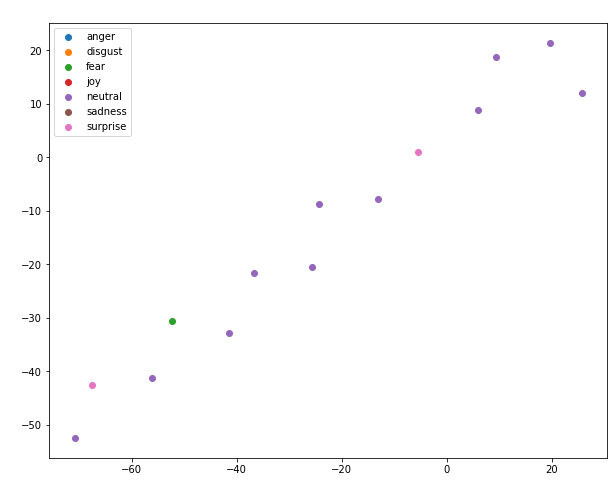

In [57]:
# Convert tensor to numpy array
h_prime_np = h_prime_mean.detach().numpy()
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)), label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()


In [58]:
runTSNE = 0

In [59]:
if runTSNE:
    # Convert tensor to numpy array
    h_prime_np = allNodeFeatsTrain.detach().numpy()
    labels = torch.tensor(y_train)
    
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)
        print(h_prime_tsne.shape)
        
        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()
